# Project #3
_____

# Modeling Process
> Authors: Si|via Resende

---

## Libraries and Dataset
____

In [1]:
# Imports
import pandas as pd 
#import matplotlib.pyplot as plt
#import seaborn as sns
#import os

#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.stem import WordNetLemmatizer

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import models.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
# Loading Dataset
subreddit = pd.read_csv('../data/subreddit_cleaned_.csv')
subreddit.drop(columns='Unnamed: 0', inplace=True)
subreddit.head(3)

,subreddit,selftext,links,youtube_links,tokens,selftext_length,selftext_word_count
0,OutOfTheLoop,"Last I heard a few years back, she pleaded gui...","[('https', 'bleacherreport.com', '/articles/24...",[],"['last', 'i', 'heard', 'a', 'few', 'year', 'ba...",218,18
1,explainlikeimfive,So a year ago around I saw a list showing the ...,[],[],"['so', 'a', 'year', 'ago', 'around', 'i', 'saw...",161,33
2,OutOfTheLoop,I've seen memes of people in Martha's Vineyard...,"[('https', 'www.reddit.com', '/r/PublicFreakou...",[],"['i', 've', 'seen', 'meme', 'of', 'peopl', 'in...",350,21


In [3]:
# Checking null values
subreddit.isnull().sum()

subreddit              0
selftext               0
links                  0
youtube_links          0
tokens                 0
selftext_length        0
selftext_word_count    0
dtype: int64

In [4]:
# Shape
subreddit.shape

(3998, 7)

In [5]:
subreddit.drop(subreddit[subreddit['tokens']=='[]'].index, axis=0, inplace=True)
subreddit.shape

(3998, 7)

In [6]:
# Getting a copy of Dataframe to working on it
df = subreddit.copy() 

# Dropping unecessary columns
df.drop(columns=['selftext','links','youtube_links'], inplace=True)
df.columns

Index(['subreddit', 'tokens', 'selftext_length', 'selftext_word_count'], dtype='object')

In [7]:
df.shape

(3998, 4)

In [8]:
# Checking types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998 entries, 0 to 3997
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   subreddit            3998 non-null   object
 1   tokens               3998 non-null   object
 2   selftext_length      3998 non-null   int64 
 3   selftext_word_count  3998 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 125.1+ KB


In [9]:
df.sort_values(by='selftext_word_count').head()

,subreddit,tokens,selftext_length,selftext_word_count
476,OutOfTheLoop,['exampl'],429,1
847,OutOfTheLoop,"['amp', 'xb']",246,1
3599,explainlikeimfive,['i'],1,1
3573,OutOfTheLoop,['exampl'],163,2
3321,OutOfTheLoop,['thank'],75,2


In [10]:
df.to_csv('../data/subreddit_EDA.csv')

### Binarizing Targets
___

In [11]:
# I know we don't necessary to biniarize, but it feels good! :]
df['subreddit'] = df['subreddit'].map({'explainlikeimfive': 0 , 'OutOfTheLoop': 1 })
df.head(3)

,subreddit,tokens,selftext_length,selftext_word_count
0,1,"['last', 'i', 'heard', 'a', 'few', 'year', 'ba...",218,18
1,0,"['so', 'a', 'year', 'ago', 'around', 'i', 'saw...",161,33
2,1,"['i', 've', 'seen', 'meme', 'of', 'peopl', 'in...",350,21


## Create `X` and `y`
---


In [12]:
X = df['tokens']
y = df['subreddit']
X.shape, y.shape

((3998,), (3998,))

In [13]:
X.head()

0    ['last', 'i', 'heard', 'a', 'few', 'year', 'ba...
1    ['so', 'a', 'year', 'ago', 'around', 'i', 'saw...
2    ['i', 've', 'seen', 'meme', 'of', 'peopl', 'in...
3    ['there', 's', 'a', 'lot', 'of', 'meme', 'onli...
4    ['i', 'found', 'out', 'there', 're', 'ban', 's...
Name: tokens, dtype: object

### Baseline Accuracy
---

In [14]:
# {'explainlikeimfive': 0 , 'OutOfTheLoop': 1 }
y.value_counts(normalize = True)

1    0.53902
0    0.46098
Name: subreddit, dtype: float64

## Train/Test Split
---

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
X_train.shape, X_test.shape

((2998,), (1000,))

In [16]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

1    0.539026
0    0.460974
Name: subreddit, dtype: float64
1    0.539
0    0.461
Name: subreddit, dtype: float64


## #1 LogisticRegression
______

### Pipeline and GridSearchCV
`Pipeline` | `TfidfVectorizer` and `LogisticRegression` 

In [17]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [18]:
pipe_params = {
    'tvec__max_features': [2000, 3000, 4000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__min_df': [2, 4],
    #'tvec__max_df': [1.0, .8, .5],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}
gs = GridSearchCV(
                pipe,
                param_grid=pipe_params,
                n_jobs = -1
                )
gs.fit(X_train, y_train);
print(f'Best Score: {round(gs.best_score_, 4)}')
print(f'Best Parameters: {gs.best_params_}') 

/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_log

Best Score: 0.8889
Best Parameters: {'lr__penalty': 'l2', 'tvec__max_features': 4000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


### Model Evaluation
---


In [19]:
# Def Evaluation
def evaluation(model, X_train_set, y_train_set, X_test_set, y_test_set, pred_set):
    
    # Train and Test Score
    print(f'Train Score: {round(model.score(X_train_set, y_train_set), 4)}')
    print(f'Test Score: {round(model.score(X_test_set, y_test_set), 4)}')
    
    # F1 e Accuracy
    print(f'F1 Score: {round(metrics.f1_score(y_test_set, pred_set), 4)}')
    print(f'Accuracy: {round(metrics.accuracy_score(y_test_set, pred_set), 4)}')
    
    # misclassification rate
    print(f'Misclassif. Train: {round(1 - model.score(X_train_set, y_train_set), 4)}')
    print(f'Misclassif. Test: {round(1 - model.score(X_test_set, y_test_set), 4)}')

In [20]:
# Evaluation
evaluation(gs, X_train, y_train, X_test, y_test, gs.predict(X_test))

Train Score: 0.9496
Test Score: 0.9
F1 Score: 0.9076
Accuracy: 0.9
Misclassif. Train: 0.0504
Misclassif. Test: 0.1


In [21]:
# Def Evaluation  Confusion Matrix
def evaluation_confusion_matrix(model, X_test_set, y_test_set, pred_set):

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test_set, pred_set).ravel()
    confusion_matrix(y_test_set, pred_set).ravel()
   
    # Plotting Matrix and RocCurve
    plot_confusion_matrix(model, X_test_set, y_test_set, display_labels = ['explainlikeimfive', 'OutOfTheLoop'])
    plot_roc_curve(model, X_test_set, y_test_set);
   
    # Calculate the specificity
    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec, 4) }')
    
    # Calculate sensitivity.
    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens, 4)}') 


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.8872
Sensitivity: 0.9109


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


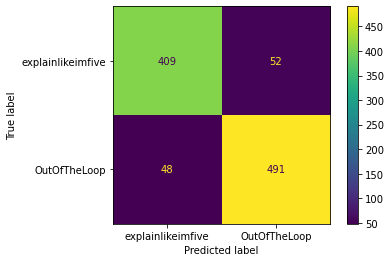

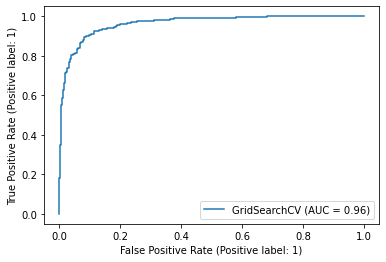

In [22]:
# Evaluation with Matrix
evaluation_confusion_matrix(gs, X_test, y_test, gs.predict(X_test))


## #2  KNNeighbors Classifier
____

### Pipeline and GridSearchCV

In [23]:
pipe_knn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])
pipe_params_knn = {
    'tvec__stop_words': [None, 'english',],
    'tvec__max_features': [3000, 3500, 4200],
    'tvec__min_df': [4, 6],
    'tvec__max_df': [1.0, .8, .5],
    'tvec__ngram_range': [(1, 1), (1, 2), (1,3)],
    'knn__n_neighbors':[ 5, 11,13]
}

gs_knn = GridSearchCV(pipe_knn,
                     param_grid=pipe_params_knn,
                     n_jobs = -1)

gs_knn.fit(X_train, y_train);
print(f'Best Score: {round(gs_knn.best_score_, 4)}')
print(f'Best Parameters: {gs_knn.best_params_}')   

Best Score: 0.8482
Best Parameters: {'knn__n_neighbors': 13, 'tvec__max_df': 0.5, 'tvec__max_features': 3000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [24]:
evaluation(gs_knn, X_train, y_train, X_test, y_test, gs_knn.predict(X_test))

Train Score: 0.8819
Test Score: 0.86
F1 Score: 0.8732
Accuracy: 0.86
Misclassif. Train: 0.1181
Misclassif. Test: 0.14


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.82
Sensitivity: 0.8942


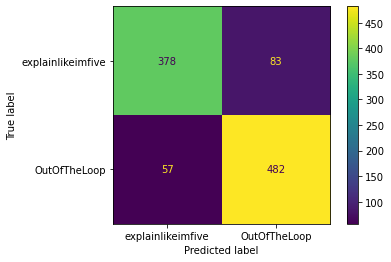

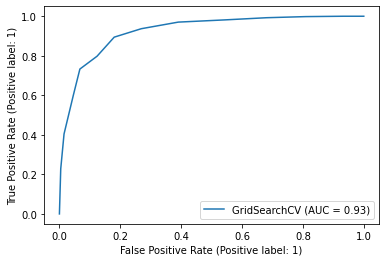

In [25]:
evaluation_confusion_matrix(gs_knn, X_test, y_test, gs_knn.predict(X_test))

## #3  Multinomial Naive Bayes 
____

In [26]:
pipe_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2, 3-grams).
pipe_params_nb = {
    'tvec__stop_words': [None, 'english',],
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2), (1,3)]
}

# Instantiate GridSearchCV.
gs_nb = GridSearchCV(pipe_nb, # what object are we optimizing?
                  param_grid=pipe_params_nb, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.
# Fit GridSearch to training data.
gs_nb.fit(X_train, y_train);
print(f'Best Score: {round(gs_nb.best_score_, 4)}')
print(f'Best Parameters: {gs_nb.best_params_}')  


Best Score: 0.8926
Best Parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


In [27]:
evaluation(gs_nb, X_train, y_train, X_test, y_test, gs_nb.predict(X_test))

Train Score: 0.946
Test Score: 0.902
F1 Score: 0.9111
Accuracy: 0.902
Misclassif. Train: 0.054
Misclassif. Test: 0.098


Specificity: 0.8677
Sensitivity: 0.9314


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


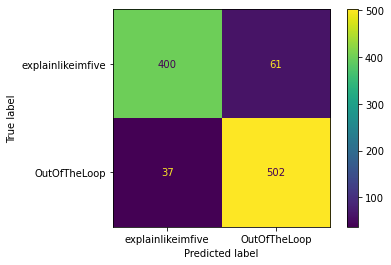

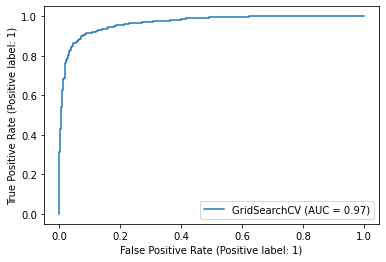

In [28]:
evaluation_confusion_matrix(gs_nb, X_test, y_test, gs_nb.predict(X_test))

## #4  Decision Trees Classifier
___

In [29]:
tvec = TfidfVectorizer(stop_words='english', ngram_range= (1,2))
tvec.fit(X_train)
X_train = tvec.transform(X_train)
X_test = tvec.transform(X_test)

In [30]:
df_tvec = pd.DataFrame(X_train.todense(), columns = tvec.get_feature_names_out())
df_tvec.columns

Index(['aa', 'aa aaa', 'aa observ', 'aaa', 'aaa size', 'aaden',
       'aaden construct', 'aav', 'aav sl', 'abandon',
       ...
       'zyurang', 'zyurang becaus', 'zyzz', 'zyzz wonder', 'ôn', 'ôn social',
       'þat', 'þat instead', '博衣こよりd', '博衣こよりd hashtag'],
      dtype='object', length=53396)

In [31]:
# Instantiate model with random_state = 42.
dt = DecisionTreeClassifier(random_state = 42)

# Fit model.
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [32]:
# Evaluate model.
evaluation(dt, X_train, y_train, X_test, y_test, dt.predict(X_test))

Train Score: 0.999
Test Score: 0.711
F1 Score: 0.7515
Accuracy: 0.711
Misclassif. Train: 0.001
Misclassif. Test: 0.289


Specificity: 0.5944
Sensitivity: 0.8108


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


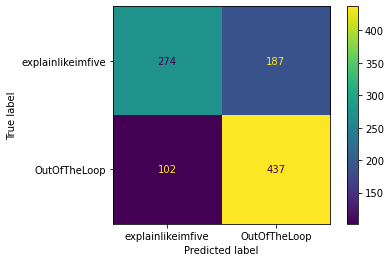

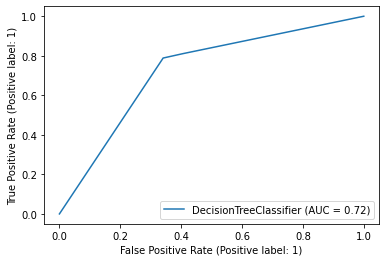

In [33]:
evaluation_confusion_matrix(dt, X_test, y_test, dt.predict(X_test))

## #5 Decision Trees GridSearch
___

### Gridsearch 

In [34]:
gs_dt = GridSearchCV(
                    estimator = DecisionTreeClassifier(),
                    param_grid = {  'max_depth': [2, 3, 5, 7],
                                    'min_samples_split': [5, 10, 15, 20],
                                    'min_samples_leaf': [2, 3, 4, 5, 6],
                                    'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    verbose = 1)
gs_dt.fit(X_train, y_train)
print(f'Best Estimator: {gs_dt.best_estimator_}')

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Estimator: DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, min_samples_leaf=3,
                       min_samples_split=5)


In [35]:
evaluation(gs_dt, X_train, y_train, X_test, y_test, gs_dt.predict(X_test))

Train Score: 0.7445
Test Score: 0.703
F1 Score: 0.7179
Accuracy: 0.703
Misclassif. Train: 0.2555
Misclassif. Test: 0.297


Specificity: 0.705
Sensitivity: 0.7013


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


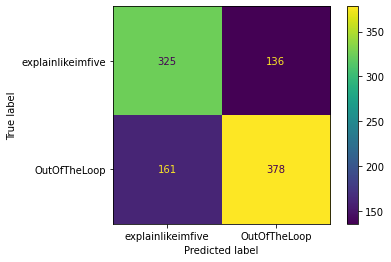

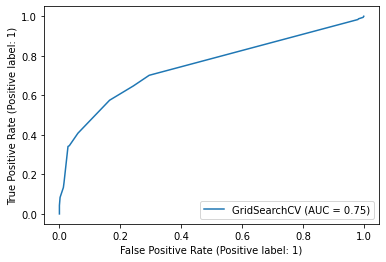

In [36]:
evaluation_confusion_matrix(gs_dt, X_test, y_test, gs_dt.predict(X_test))

## #6 Decision Trees Bagging
___

### Bagging 

In [37]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(random_state = 42)

# Fit BaggingClassifier.
bag.fit(X_train, y_train)

BaggingClassifier(random_state=42)

In [38]:
evaluation(bag, X_train, y_train, X_test, y_test, bag.predict(X_test))

Train Score: 0.9837
Test Score: 0.756
F1 Score: 0.7897
Accuracy: 0.756
Misclassif. Train: 0.0163
Misclassif. Test: 0.244


Specificity: 0.6464
Sensitivity: 0.8497


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


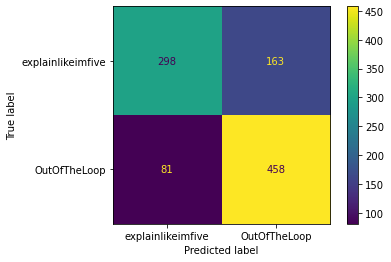

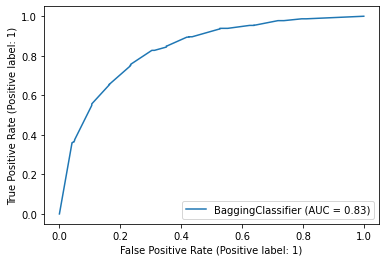

In [39]:
evaluation_confusion_matrix(bag, X_test, y_test, bag.predict(X_test))

## #7 Random Forests Classifier
___

In [40]:
rf = RandomForestClassifier(n_estimators = 100)

### GridSearch 

In [41]:
rf_params = {
    'n_estimators': [200, 250, 300, 400, 500],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7],
    'n_jobs': [-1]
}

gs_rf = GridSearchCV(rf, param_grid=rf_params, cv = 5)

gs_rf.fit(X_train, y_train)

print(f'Best Score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Best Score: 0.8525692821368949
Best Parameters: {'max_depth': None, 'n_estimators': 300, 'n_jobs': -1}


In [42]:
evaluation(gs_rf, X_train, y_train, X_test, y_test, gs_rf.predict(X_test))

Train Score: 0.999
Test Score: 0.837
F1 Score: 0.8608
Accuracy: 0.837
Misclassif. Train: 0.001
Misclassif. Test: 0.163


Specificity: 0.7223
Sensitivity: 0.9351


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


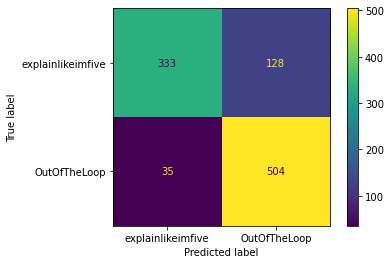

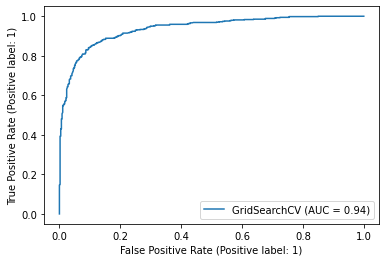

In [43]:
evaluation_confusion_matrix(gs_rf, X_test, y_test, gs_rf.predict(X_test))

## #8 Extra Trees Classifier
___

In [44]:
et = ExtraTreesClassifier()

### GridSearch 

In [45]:
et_params = {
    'n_estimators': [100, 200, 250, 300, 400, 500],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7],
    'n_jobs': [-1]
}

gs_et = GridSearchCV(et, param_grid=et_params, cv = 5)

gs_et.fit(X_train, y_train)

print(f'Best Score: {gs_et.best_score_}')
print(f'Best Parameters:{gs_et.best_params_}')

Best Score: 0.865243183082916
Best Parameters:{'max_depth': None, 'n_estimators': 500, 'n_jobs': -1}


In [46]:
evaluation(gs_et, X_train, y_train, X_test, y_test, gs_et.predict(X_test))

Train Score: 0.999
Test Score: 0.86
F1 Score: 0.8768
Accuracy: 0.86
Misclassif. Train: 0.001
Misclassif. Test: 0.14


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.7852
Sensitivity: 0.9239


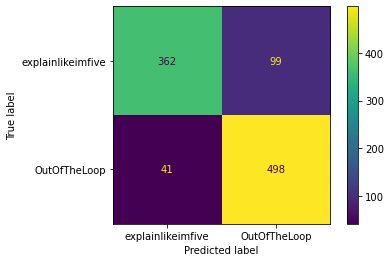

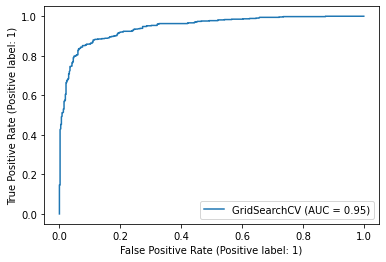

In [47]:
evaluation_confusion_matrix(gs_et, X_test, y_test, gs_et.predict(X_test))

## #9 AdaBoost for Extra Random Trees
___


In [48]:
ada = AdaBoostClassifier(base_estimator = ExtraTreesClassifier())

ada_params = {
    'n_estimators': [50, 100],
    'base_estimator__max_depth': [1, 2],
    'learning_rate': [0.9, 1.01],
}

gs_ada = GridSearchCV(ada, param_grid = ada_params, cv = 3)
gs_ada.fit(X_train, y_train)

print(f'Best Prameters: {gs_ada.best_params_}')
print(f'Best Score: {gs_ada.best_score_}')


Best Prameters: {'base_estimator__max_depth': 1, 'learning_rate': 1.01, 'n_estimators': 100}
Best Score: 0.8655752419085753


In [49]:
evaluation(gs_ada, X_train, y_train, X_test, y_test, gs_ada.predict(X_test))

Train Score: 0.9266
Test Score: 0.862
F1 Score: 0.8748
Accuracy: 0.862
Misclassif. Train: 0.0734
Misclassif. Test: 0.138


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.8243
Sensitivity: 0.8942


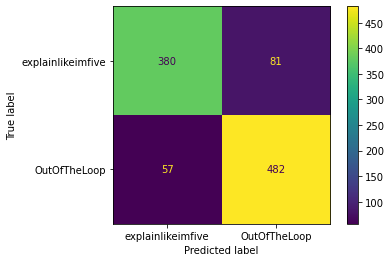

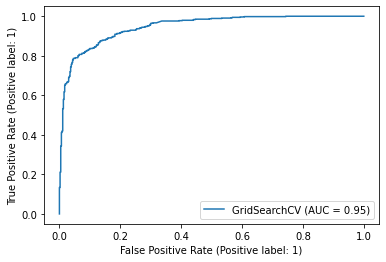

In [50]:
evaluation_confusion_matrix(gs_ada, X_test, y_test, gs_ada.predict(X_test))

## #10 AdaBoost for Logistic Regression
___

In [51]:
ada_lr = AdaBoostClassifier(base_estimator = LogisticRegression())

ada_lr_params = {
    'n_estimators': [50, 100],
    'base_estimator__C': [0.01, 0.1, 1.0],
    'learning_rate': [0.9, 1.0]
}
gs_ada_lr = GridSearchCV(ada_lr, param_grid=ada_lr_params,
                        cv = 3)

gs_ada_lr.fit(X_train, y_train)
print(f'Best Score: {gs_ada_lr.best_score_}')
print(f'Best Parameters: {gs_ada_lr.best_params_}')

Best Score: 0.5410273606940273
Best Parameters: {'base_estimator__C': 1.0, 'learning_rate': 1.0, 'n_estimators': 100}


In [52]:
evaluation(gs_ada, X_train, y_train, X_test, y_test, gs_ada_lr.predict(X_test))

Train Score: 0.9266
Test Score: 0.862
F1 Score: 0.7033
Accuracy: 0.546
Misclassif. Train: 0.0734
Misclassif. Test: 0.138


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.8243
Sensitivity: 0.8942


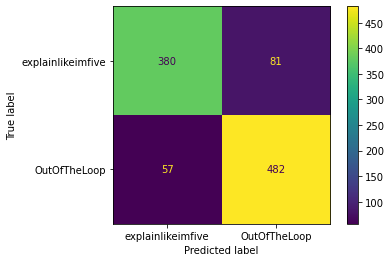

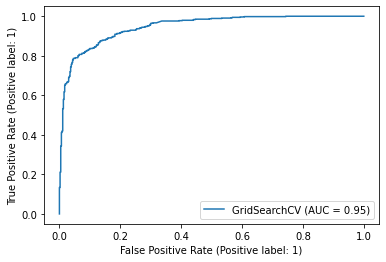

In [53]:
evaluation_confusion_matrix(gs_ada,X_test, y_test, gs_ada.predict(X_test))

## #11 AdaBoost for Multinomial Naive Bayes
___

In [54]:
ada_nb = AdaBoostClassifier(base_estimator = MultinomialNB())

ada_nb_params = {
    'base_estimator__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.9, 1.0]
}
gs_ada_nb = GridSearchCV(
                        ada_nb, 
                        param_grid=ada_nb_params,
                        cv = 3
)
gs_ada_nb.fit(X_train, y_train)

print(f'Best Parameters: {gs_ada_nb.best_params_}')
print(f'Best Score: {gs_ada_nb.best_score_}')

Best Parameters: {'base_estimator__alpha': 0.1, 'learning_rate': 1.0, 'n_estimators': 200}
Best Score: 0.871911911911912


In [55]:
evaluation(gs_ada_nb, X_train, y_train, X_test, y_test, gs_ada_nb.predict(X_test))

Train Score: 0.9807
Test Score: 0.88
F1 Score: 0.8934
Accuracy: 0.88
Misclassif. Train: 0.0193
Misclassif. Test: 0.12


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.8178
Sensitivity: 0.9332


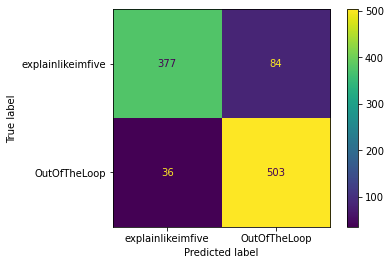

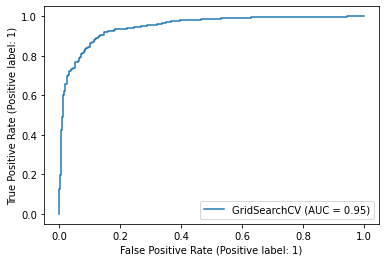

In [56]:
evaluation_confusion_matrix(gs_ada_nb, X_test, y_test, gs_ada_nb.predict(X_test))

## #12 Gradient Boosting Classifier 
___

In [57]:
gboost = GradientBoostingClassifier()

gboost_params = {
    'max_depth': [2, 3, 4, 5, 6],
    'n_estimators': [100, 125, 150],
    'learning_rate': [0.8, 1.0, 0.1]
}

gb_gs = GridSearchCV(gboost, param_grid=gboost_params, cv = 3)
gb_gs.fit(X_train, y_train)

print(f'Best Score: {gb_gs.best_score_}')
print(f'Best Parameters: {gb_gs.best_params_}')


Best Score: 0.8212098765432098
Best Parameters: {'learning_rate': 0.8, 'max_depth': 6, 'n_estimators': 125}


In [58]:
evaluation(gb_gs, X_train, y_train, X_test, y_test, gb_gs.predict(X_test))

Train Score: 0.9987
Test Score: 0.82
F1 Score: 0.8415
Accuracy: 0.82
Misclassif. Train: 0.0013
Misclassif. Test: 0.18


Specificity: 0.7419
Sensitivity: 0.8868


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


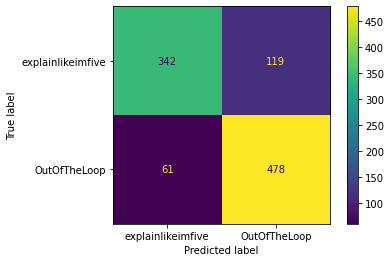

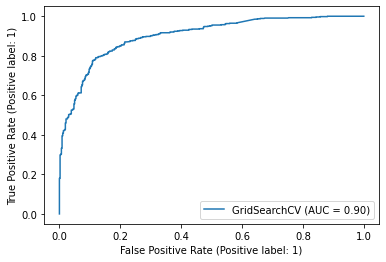

In [59]:
evaluation_confusion_matrix(gb_gs, X_test, y_test, gb_gs.predict(X_test))

## #13 Voting Classifier
___


In [60]:
vote = VotingClassifier([
    ('tree', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
])
vote_params = {
    'ada__n_estimators': [50, 75, 100],
    'gb__n_estimators': [100, 125, 200],
    'tree__max_depth':[None, 5]
}
gs_vt = GridSearchCV(vote, param_grid=vote_params, cv = 3)

gs_vt.fit(X_train, y_train)

print(f'Best Score: {gs_vt.best_score_}')
print(f'Best Parameters: {gs_vt.best_params_}')

Best Score: 0.8215468802135469
Best Parameters: {'ada__n_estimators': 100, 'gb__n_estimators': 200, 'tree__max_depth': None}


In [61]:
evaluation(gs_vt, X_train, y_train, X_test, y_test, gs_vt.predict(X_test))

Train Score: 0.9496
Test Score: 0.831
F1 Score: 0.8476
Accuracy: 0.831
Misclassif. Train: 0.0504
Misclassif. Test: 0.169


Specificity: 0.7831
Sensitivity: 0.872


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


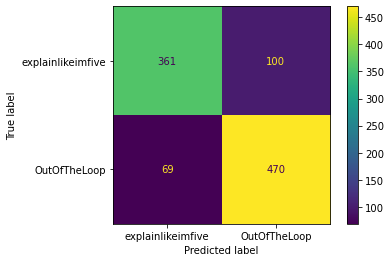

In [62]:
tn, fp, fn, tp = confusion_matrix(y_test, gs_vt.predict(X_test)).ravel()
confusion_matrix(y_test, gs_vt.predict(X_test)).ravel()
   
# Plotting Matrix and RocCurve
plot_confusion_matrix(gs_vt, X_test, y_test, display_labels = ['explainlikeimfive', 'OutOfTheLoop'])

   
# Calculate the specificity
spec = tn / (tn + fp)
print(f'Specificity: {round(spec, 4) }')
    
# Calculate sensitivity.
sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens, 4)}') 

## #14 Voting Classifier with Pipeline 
___

In [65]:
lr_pipe = Pipeline([
    ('lr', LogisticRegression())
])

nb_pipe = Pipeline([
    ('nb', MultinomialNB())
])

vote = VotingClassifier([
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('nb_pipe', nb_pipe),
    ('lr_pipe', lr_pipe)
])

vote_params = {
    'ada__n_estimators':[50, 75],
    'gb__n_estimators':[100],
    'lr_pipe__lr__penalty': ['l1', 'l2', 'none'],
    'nb_pipe__nb__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gs_vt2 = GridSearchCV(vote, param_grid=vote_params)
gs_vt2.fit(X_train, y_train)

print(f'Best Score:{gs_vt2.best_score_}')
print(f'Best Parameters:{gs_vt2.best_params_}')


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voting.py", line 351, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_voti

Best Score:0.8515687256538677
Best Parameters:{'ada__n_estimators': 75, 'gb__n_estimators': 100, 'lr_pipe__lr__penalty': 'l2', 'nb_pipe__nb__alpha': 0.1}


In [66]:
evaluation(gs_vt2, X_train, y_train, X_test, y_test, gs_vt2.predict(X_test))

Train Score: 0.9326
Test Score: 0.857
F1 Score: 0.8662
Accuracy: 0.857
Misclassif. Train: 0.0674
Misclassif. Test: 0.143


0.8662301216089805
Confusion Matrix: 
 [[394  67]
 [ 76 463]]

Sensitivity: 0.859
Specificity: 0.8547


/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


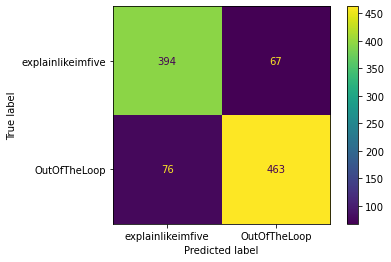

In [67]:
# Generate predictions on test set.
preds_vt_pipe = gs_vt2.predict(X_test)

print(metrics.f1_score(y_test, preds_vt_pipe))

# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test,
                                  preds_vt_pipe).ravel()

print(f'Confusion Matrix: \n {confusion_matrix(y_test, preds_vt_pipe)}\n')
plot_confusion_matrix(gs_vt2, X_test, y_test, display_labels = ['explainlikeimfive', 'OutOfTheLoop'])

# Calculate sensitivity.
sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens, 4)}')

# Calculate specificity.
spec = tn / (tn + fp)
print(f'Specificity: {round(spec, 4)}')

## Evaluation Models 
_____


As mentioned earlier, the metric chosen to evaluate the models was the F1 score. F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.[3]

F1 Score = 2 * (Recall * Precision) / (Recall + Precision)


![](../images/TableMetrics.png) 

#### MULTINOMIAL NAÏVE BAEYS
----

Best Parameters: 
{  \
'tvec__max_df': 0.9,    # Maximum number of documents needed to include token (90%) \
‘tvec__max_features': 5000, # Maximum number of features fit.       \
'tvec__min_df': 3, # Minimum number of documents needed to include token (3). \
'tvec__ngram_range': (1, 2), # Check (individual tokens) and also check 2-grams. \
'tvec__stop_words': None  # Remove stop words (None) \
} 

Train Score: 0.946 \
Test Score: 0.902 \
F1 Score: 0.9111 \ 
Accuracy: 0.902 \ 

#### LOGISTIC REGRESSION
----


Best Parameters: \
{   \
'lr__penalty': 'l2', \
'tvec__max_features': 4000, \
'tvec__min_df': 4, \
'tvec__ngram_range': (1, 2), \
'tvec__stop_words': None \
} 

Train Score: 0.9496 \
Test Score: 0.9 \
F1 Score: 0.9076 \
Accuracy: 0.9 

## Conclusion and Recommendations 

----

Looking at the metrics in the training and test sets, we can verify that both models are not overfitting or have high bias and based on the F1 score metric (and also accuracy), we can say that both models perform very well in the forecast from these two subreddits. Another conclusion is that there doesn't seem to be much overlap in terms, otherwise it wouldn't perform as well.

## Future Works 
----



• Perform a Test Validation: Get more data from each subreddit and placement a test in unseen data; \
• Add Information to Documents: Adding information to the model from links extracted from the documents (YouTube links); \
• Others Subreddits: Applying to others subreddits to check if the model performs well; \
• Frame a Different Statement: Evaluate using different metrics to check the model performance (Sensitivity/Recall). Maybe we can think about a scenario where it makes sense to rank one class more than the other. For example, consider that the ELI5 profile is a person who is learning the English language and needs explanations about a certain subject in a simple and lay language.

## References
----

[1][*Explain Like I'm Five*](https://www.reddit.com/r/explainlikeimfive/)  \
[2][*Subreddit Out of the Loop*](https://www.reddit.com/r/OutOfTheLoop/)  \
[3][*F1 Score*](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) 